# Using fastText to classify reddit submissions

## A quick and dirty tutorial

Will Radford - @wejradford

# fastText

Concerted programme of research from Facebook towards practical text classification. Three key papers from 2016:
* [Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606)
* [Bag of Tricks for Efficient Text Classification](https://arxiv.org/abs/1607.01759)
* [FastText.zip: Compressing text classification models](https://arxiv.org/abs/1612.03651)

Open source at [GitHub](https://github.com/facebookresearch/fastText) and [elsewhere](https://fasttext.cc/)

# How does it work?

![title](https://github.com/wejradford/wejradford.github.io/raw/master/fastTextArch.png)

* Lowest layer maps n-grams to `d`-dimension word embeddings (à la word2vec) _smushed_ together with averaging.
* Hidden layer maps each dimension to a weight.
* Top layer is the label.

# Mixing neural and shallow models

* Word embeddings for a **task-specific** representation
* Linear models for **fast** learning and prediction
  
$\rightarrow$ **Faster and hopefully better than bag-of-words**

# Dealing with large vocabulary

* Word n-grams give more context than words alone
```python
>>> tokens('the cat sat on the mat')
['the', 'cat', 'sat', 'on', 'the', 'mat']
>>> ngrams('the cat sat on the mat')
['START_the', 'the_cat', 'cat_sat', 'sat_on', 'on_the', 'the_mat', 'mat_END']
```
* But:
  * Much sparser features (more zeros than non-zeros)
  * Need to maintain the mappings from `sat_on` to `feature_12345`, which costs memory and slows multicore learning

* _The hashing trick_ (see also [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit) maps n-grams into a constrained memory space

$\rightarrow$ **More memory-efficient and parallelisable learning**

# Classifying in large label spaces

* Linear classifiers run at $O(fk)$ where:
  * $f$ the number of features (i.e. dimensions)
  * $k$ is the number of labels
* Hierarchical softmax reduces this to $O(f\log_{2}k)$ by building a tree of labels arranged by probability.

$\rightarrow$ **Faster with some accuracy cost**

# Compressing models

* Large models limit the deployment environment and increase load time
* _Vector quantisation_ lossily compresses the model

$\rightarrow$ **Smaller models at some accuracy cost**

# Handling unseen words

* Bag-of-words limits the model to handling those words seen in training (maybe not for hashing...).
* Learn **character** n-grams embeddings to handle morphology (e.g. "**mak**e", "**mak**ing", "**mak**o") and unknown words.
* Pre-initialising word embeddings with those learned from different corpora.

$\rightarrow$ **More robust models**

# A toy task

* Reddit submissions collected at http://files.pushshift.io/reddit/submissions/
* Downloadable as `json`
  * `title` The title of the submission
  * `subreddit` The subreddit it was submitted to
  
$\rightarrow$ Given the `title`, predict which `subreddit` it belongs to.

## Installation

* Install [homebrew](https://brew.sh) if you're on Mac OSX
* Install python3 and some packaging utilities:
```bash
brew install python3
pip3.6 install -U pip wheel
```
* Clone the [fastText](https://github.com/facebookresearch/fastText) repo, and build `fastText`:
```bash
git clone https://github.com/facebookresearch/fastText.git
cd fastText
make
```
* If you want to use the python bindings (we don't here):
```bash
cd python
pip3.6 install numpy scipy pybind11
python3.6 setup bdist_wheel
pip3 install dist/*whl
```
* Install the notebook environment:
```bash
pip3 install jupyter seaborn ujson nltk sklearn
jupyter notebook
```
* Fetch the data:
```bash
wget http://files.pushshift.io/reddit/submissions/RS_2017-08.bz2
```

# Preprocessing

* Take each post
* Find the first sentence
* Apply a `really dumb tokeniser to split words !`
* Use the subreddit topic as the label

# Streaming through reddit submissions

* First 50K used to find the top-20 common labels (plus `other`), and for training embeddings
* Next 10K for training
* Next 10K for development
* Next 1K for test

# Training the model

* Wrap command-line `fastText` using some python
* Call and predict, returning:
  * Precision
  * Recall
  * F1
  * Training time
  * Model size

# Sanity-check baseline 

* Using `scikit-learn`, nothing fancy
* Bag of words (unigrams and bigrams)
* Logistic regression prediction

In [1]:
% matplotlib inline
import bz2
from collections import Counter
import lzma
import os
import pprint
import re
import subprocess
import time

import ujson as json
import pandas as pd
import seaborn as sns
sns.set_context('talk')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.externals import joblib
from matplotlib import pyplot as plt

In [2]:
# Tokenisation expression.
EXP = re.compile('\w+|\$[\d\.]+|\S+')
FINAL = {'.', '?', '!'}


def get_first_sentence(s):
    """ A very naïve method for finding
    the first sentence.
    
    Returns:
        A whitespace-normalised version of the sentence.
    """
    tokens = []
    for m in EXP.finditer(s.replace('\n', ' ')):
        t = m.group(0)
        if not t.strip():
            continue
        if t in FINAL or len(tokens) == 50:
            break
        tokens.append(t)
    return ' '.join(tokens)


def write_data(data, fname, write_label=True):
    """ Writes data to file in fastText format. """
    with open(fname, 'w') as f:
        for label, text in data:
            if write_label:
                f.write('__label__{} {}\n'.format(label, text))
            else:
                f.write('{}\n'.format(text))

In [3]:
def iter_reddit(fname):
    """ Yields tuples of (created, subreddit, sentence). """
    _open = open
    if fname.endswith('.xz'):
        _open = lzma.open
    elif fname.endswith('.bz2'):
        _open = bz2.open
    with _open(fname) as f:
        read = 0
        for l in f:
            l = json.loads(l)
            # pprint.pprint(l)
            sentence = get_first_sentence(l['title'])
            if not sentence:
                continue
            subreddit = l.get('subreddit')
            if subreddit is None:
                continue
            yield l['created_utc'], subreddit, sentence
            read += 1

In [4]:
def build_data(fname):
    """ Passes through the data, collecting and returning some datasets. """
    burnin = []
    train = []
    dev = []
    test = []
    burnin_n = 100000
    train_n = 10000
    dev_n = 1000
    test_n = 1000
    subreddits = Counter()
    top_20_subreddits = None
    print('Finding {} sentences for burnin'.format(burnin_n))
    for i, (created, subreddit, body) in enumerate(iter_reddit(fname)):
        if 'dirty' in subreddit.lower():
            continue
        # Get a count of common subreddits.
        if i < burnin_n:
            subreddits[subreddit] += 1
            burnin.append(body)
            continue
        elif not top_20_subreddits:
            top_20_subreddits = set(k for k, _ in subreddits.most_common(20))
            print('Found top 20 subreddits {}'.format(top_20_subreddits))
        elif subreddit not in top_20_subreddits:
            continue
        
        if i % 1000 == 0:
            print('Collected train/dev/test {}/{}/{}'.format(len(train), len(dev), len(test)))

        if len(train) < train_n:
            train.append((subreddit, body))
        elif len(dev) < dev_n:
            dev.append((subreddit, body))
        elif len(test) < test_n:
            test.append((subreddit, body))
        else:
            break
    print('Collected train/dev/test {}/{}/{}'.format(len(train), len(dev), len(test)))
    return burnin, train, dev, test

In [5]:
def setup_data(clean=False):
    """ Sets up the data -- CAUTION: this can take a bit... """
    if clean and os.path.exists('train.json'):
        os.remove('train.json')
    if not os.path.exists('train.json'):
        burnin, train, dev, test = build_data('/Users/admin/fastText-tute/RS_2017-08.bz2')
        for data, fname in ((burnin, 'burnin.json'), (train, 'train.json'), 
                            (dev, 'dev.json'), (test, 'test.json')):
            with open(fname, 'w') as f:
                f.write(json.dumps(data))
    else:
        burnin = json.loads(open('burnin.json').read())
        train = json.loads(open('train.json').read())
        dev = json.loads(open('dev.json').read())
        test = json.loads(open('test.json').read())
    return burnin, train, dev, test

        
burnin, train, dev, test = setup_data(True)

Finding 100000 sentences for burnin
Found top 20 subreddits {'newsbotbot', 'AskReddit', 'GlobalOffensiveTrade', 'RocketLeagueExchange', 'aww', 'Overwatch', 'AutoNewspaper', 'gonewild', 'MemezForDayz', 'gameofthrones', 'The_Donald', 'business', 'Showerthoughts', 'gaming', 'pics', 'funny', 'videos', 'Ice_Poseidon', 'news', 'me_irl'}
Collected train/dev/test 0/0/0
Collected train/dev/test 931/0/0
Collected train/dev/test 3011/0/0
Collected train/dev/test 4037/0/0
Collected train/dev/test 5511/0/0
Collected train/dev/test 5663/0/0
Collected train/dev/test 6523/0/0
Collected train/dev/test 7155/0/0
Collected train/dev/test 7946/0/0
Collected train/dev/test 8147/0/0
Collected train/dev/test 9690/0/0
Collected train/dev/test 10000/542/0
Collected train/dev/test 10000/801/0
Collected train/dev/test 10000/948/0
Collected train/dev/test 10000/1000/1000


In [6]:
def fastText(train, test, name='fastText', ngrams=2, epoch=90, bucket=200000, dim=50,
             maxn=1,
             vectors=None, quantize=False, report=True):
    """ Trains supervised fastText models. """
    train_fname = 'train.txt'
    test_fname = 'test.txt'
    model_fname = 'model'
    write_data(train, train_fname)
    write_data(test, test_fname)
    cmd = 'fastText/fasttext'
    args = [
        'supervised',
        '-input {}'.format(train_fname),
        '-output {}'.format(model_fname),
        '-wordNgrams {}'.format(ngrams),
        '-epoch {}'.format(epoch),
        '-bucket {}'.format(bucket),
        '-dim {}'.format(dim),
        '-maxn {}'.format(maxn),
        '-loss hs',
    ]
    if vectors:
        args.append('-pretrainedVectors {}'.format(vectors))
    start = time.time()
    output = subprocess.getoutput('{} {} 2> model.log'.format(cmd, ' '.join(args)))
    if quantize:
        cmd = 'fastText/fasttext'
        args = [
            'quantize',
            '-input {}'.format(train_fname),
            '-output {}'.format(model_fname),
            '-qnorm -retrain -epoch 1 -cutoff 100000',
        ]
        output = subprocess.getoutput('{} {} 2> quant.log'.format(cmd, ' '.join(args)))
    elapsed = time.time() - start
    model_fname = 'model.bin' if not quantize else 'model.ftz'
    test_fname = 'test.txt'
    cmd = 'fastText/fasttext predict'
    args = [
        model_fname,
        test_fname,
    ]
    output = subprocess.getoutput('{} {} 2> predict.log'.format(cmd, ' '.join(args)))
    Y_test = [i[0] for i in test]
    pred = [l.strip().replace('__label__', '') for l in output.strip().split('\n')]
    stat = os.stat(model_fname)
    if report:    
        print(metrics.classification_report(Y_test, pred))
    return {
        'p': metrics.precision_score(Y_test, pred, average='micro'),
        'r': metrics.recall_score(Y_test, pred, average='micro'),
        'f': metrics.f1_score(Y_test, pred, average='micro'),
        'time': elapsed,
        'size': stat.st_size,
        'name': name,
        'ngrams': ngrams, 
        'epoch': epoch, 
        'bucket': bucket, 
        'dim': dim,
        'maxn': maxn,
        'vectors': vectors is not None,
        'quantize': quantize,
    }

In [7]:
def to_xy(data):
    """ Transforms a list of (label, text) tuples to lists as per sklearn. """
    X, Y = [], [] 
    for label, text in data:
        X.append(text)
        Y.append(label)
    return X, Y


def baseline(train, test, name='baseline', penalty='l2', C=10, report=True):
    """ Trains a baseline model. """
    c = Pipeline([
        ('vec', HashingVectorizer(ngram_range=(1, 2))),
        ('clf', LogisticRegression(penalty=penalty, C=C)),
    ])
    X_train, Y_train = to_xy(train)
    start = time.time()
    c.fit(X_train, Y_train)
    elapsed = time.time() - start
    X_test, Y_test = to_xy(test)
    pred = c.predict(X_test)
    model_fname = 'model.sklearn'
    joblib.dump(c, model_fname)
    stat = os.stat(model_fname)
    if report:
        print(metrics.classification_report(Y_test, pred))
    return {
        'p': metrics.precision_score(Y_test, pred, average='micro'),
        'r': metrics.recall_score(Y_test, pred, average='micro'),
        'f': metrics.f1_score(Y_test, pred, average='micro'),
        'time': elapsed,
        'size': stat.st_size,
        'name': name,
    }

# Manual hyper-parameter optimisation

Train on `train`, measure on `dev`.

## Baseline

In [8]:
baseline_results = []
for p in ('l2',):
    for c in (0.1, 1, 10, 100):
        print('{}\t{}'.format(p, c))
        baseline_results.append(baseline(train, dev, 
                                         name='baseline-{}-{}'.format(p, c), 
                                         penalty=p, C=c, report=False))

l2	0.1
l2	1
l2	10
l2	100


In [9]:
for r in sorted(baseline_results, key=lambda d: d['f'], reverse=True):
    print('{:.2f}\t{}\t{}'.format(r['f'], r['name'], r['time']))

0.69	baseline-l2-100	27.691969871520996
0.68	baseline-l2-10	22.016381978988647
0.63	baseline-l2-1	14.492698907852173
0.49	baseline-l2-0.1	10.064432859420776


## fastText

In [10]:
dim_results = []
for epoch in (80, 90, 100):
    for dim in (50, 100, 200):
        for bucket in (100000, 200000, 300000):
            name = 'fastText-e{}-d{}-b{}'.format(epoch, dim, bucket)
            dim_results.append(fastText(train, dev, name, 
                                            bucket=bucket, epoch=epoch, 
                                            ngrams=2, dim=dim, 
                                            report=False))

In [11]:
for r in list(sorted(dim_results, key=lambda i: i['f'], reverse=True))[:5]:
    print('{:.2f}\t{}\t{}'.format(r['f'], r['name'], r['time']))

0.68	fastText-e80-d200-b300000	16.47849178314209
0.68	fastText-e100-d50-b100000	5.685117959976196
0.68	fastText-e90-d100-b300000	10.012304782867432
0.68	fastText-e80-d200-b100000	11.206809043884277
0.68	fastText-e80-d50-b100000	4.583491086959839


In [12]:
results = []
results.append(baseline(train, test, name='baseline', penalty='l2', C=10, report=False))
results.append(fastText(train, test, 
                        name='fastText', 
                        ngrams=2,
                        epoch=90, dim=50, bucket=300000, report=False))
results.append(fastText(train, test, 
                        name='fastText-quantized', 
                        ngrams=2,
                        epoch=90, dim=50, bucket=300000, report=False, quantize=True))
df = pd.DataFrame(results, columns=['name', 'time', 'size', 'p', 'r', 'f'])
df['size'] /= 1000000

# Data



In [31]:
data_stats = pd.DataFrame([{'Label': k, 'Count': v} for k, v in 
              Counter((i[0] for i in train)).items()]).sort_values('Count', ascending=False)
data_stats[:10]

,Count,Label
16,1700,AutoNewspaper
11,1248,AskReddit
1,1085,GlobalOffensiveTrade
6,740,news
4,691,RocketLeagueExchange
7,637,newsbotbot
17,473,The_Donald
5,472,business
15,459,videos
8,389,Showerthoughts


In [32]:
data_stats[10:]

,Count,Label
2,349,funny
3,278,me_irl
9,272,gameofthrones
14,262,gaming
13,225,aww
10,207,pics
18,172,Overwatch
19,151,MemezForDayz
12,140,gonewild
20,49,Ice_Poseidon


In [33]:
data_df = pd.DataFrame([{'Text': t, 'Label': l} for l, t in train[:10]])
data_df

,Label,Text
0,ShittyCarMod,Maserati with an Aerodynamic Spoiler
1,GlobalOffensiveTrade,"[Store] Double moses M9 #355, Dual side blue g..."
2,funny,Adam Mišík – Tak pojď
3,me_irl,me 🌞irl
4,RocketLeagueExchange,[ps4] [h] crimsom mantis [w] offers key prefer
5,business,Edible Prints on Cake
6,funny,RT @naukhaizs: #pakistan #karachi #lahore #isl...
7,news,"10 ảnh avatar buồn , thất tình , tâm trạng dàn..."
8,newsbotbot,"@washingtonpost: For Facebook , erasing hate s..."
9,Showerthoughts,Russia vs USA


# Results

Comparing models trained on `train`, hyperparameters tuned on `development` and evaluated on `test`:
* `baseline` model with L2 regularisation, C10
* `fastText` model with epoch 90, dimensions=50
* `fastText-quantized` model as above but quantized

In [13]:
df

,name,time,size,p,r,f
0,baseline,21.397510,176.164019,0.692,0.692,0.692
1,fastText,6.789109,64.886967,0.689,0.689,0.689
2,fastText-quantized,54.206348,3.623718,0.702,0.702,0.702


In [14]:
def plot(df):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df.plot(kind='bar', x='name', y='size', ax=ax, color='blue', alpha=0.5, position=0, width=0.3)
    df.plot(kind='bar', x='name', y='time', ax=ax2, color='red', alpha=0.5, position=1, width=0.3)

# Size vs Time

* Left-to-right: `baseline`, `fastText`, `fastText-quantized`
* `fastText` smaller and quicker to train than `baseline`
* `fastText-quantized` smaller again, but much slower to train

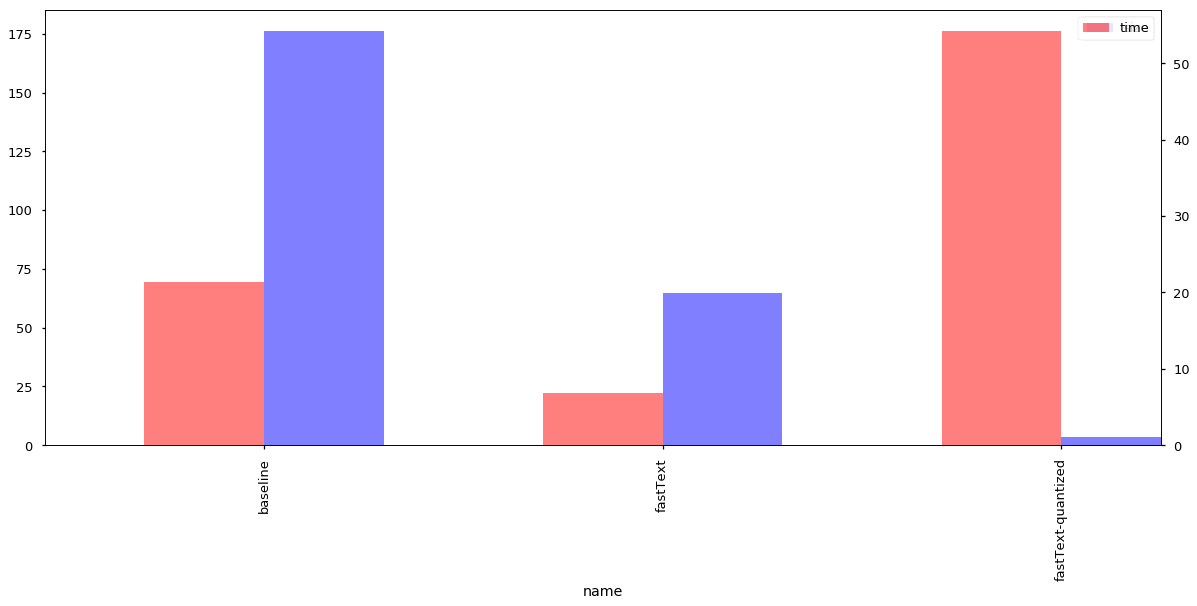

In [15]:
plot(df)

# Performance 

* very similar performance
* quantisation makes little impact on F1 score

$\rightarrow$ **significant difference, probably not...**

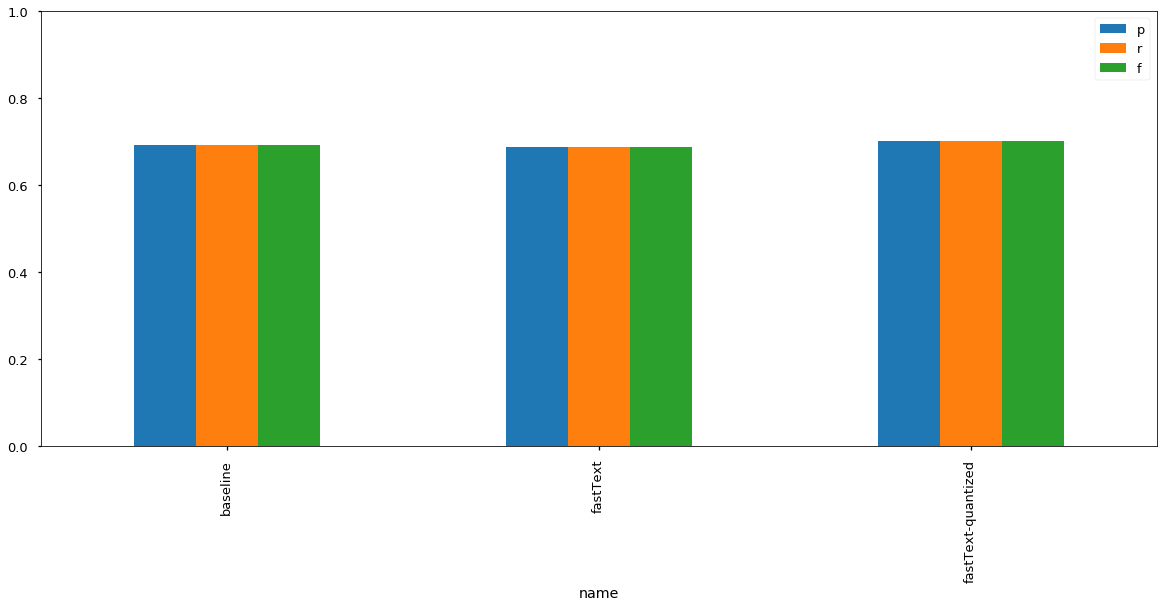

In [16]:
df.plot(kind='bar', x='name', y=['p', 'r', 'f'], ylim=(0, 1), figsize=(20, 8))

# What I didn't look at here

* Sub-word embeddings for performance on unknown words.
* Not using hierarchical softmax to give slower, but better models.
* Pre-initialising with other word embeddings.

# Conclusions

`fastText` is worth trying.
* Works relatively well for text (see also `*Sem` "embed all the things")
* Can have small model sizes (for mobile or serverless platforms)
* Trains quickly enough to tune and spend time getting more data

# Thanks!